# PCA extraction from Neurosynth

In [37]:
from neurosynth import meta, decode, network, Dataset # to work with the neurosynth dataset
import pandas
import os
import numpy as np
from matplotlib import pyplot as plt # to plot some things here
from sklearn.decomposition import PCA # to run PCA 
from sklearn.preprocessing import scale, MinMaxScaler # to scale PCA scores to be between 0 and 255, for visualization
from nilearn import plotting # to plot brain slices
import nilearn
import pickle # to load existing files
from scipy import spatial # to extract the convex hull
import cortex

In [18]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size
def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)
def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

In [38]:
# to avoid running this command I pickled a local version of the output:
dataset = pickle_load("dataset.p")

# the neurosynth database can be downloaded from https://github.com/neurosynth/neurosynth-data
# dataset = Dataset('neurosynth-data/database.txt')

In [48]:
# this is a list of all neurosynth terms
terms = pandas.read_csv('analysis_filter_list.tsv',delimiter='\t')
# but we're only interested in the terms that are non-anatomical
terms_anatfilter = pandas.read_csv('neurosynth_terms_anatfilter.txt',delimiter='\t')

In [49]:
# only keep terms that have a 'keep' value of 1 and n 'anatmoical' value of 0
kept_terms_anatfilter = terms_anatfilter['term'][np.logical_and(terms_anatfilter['keep']==1, terms_anatfilter['anatomical']==0)]
# we will take these terms and find their location in a list that is ordered alphabetically
kept_terms = terms['term'][terms['keep']==1]
anatfilter_indices = [i for i,k in enumerate(list(kept_terms)) if k in list(kept_terms_anatfilter)]
kept_terms_anatfilter = kept_terms.iloc[anatfilter_indices]

In [66]:
# this step will take a few hours to run. It involves extracting and saving the brain map for each term.
maps = {}
for term in kept_terms:
    ids = dataset.get_studies(term)
    ma = meta.MetaAnalysis(dataset, ids)
    maps[term] = ma.images['association-test_z']
    ma.save_results(os.path.join('neurosynth-data','maps',term))

In [102]:
# and saving everything to one 2d array
concat_maps = np.vstack((maps[k] for k in maps.keys()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [20]:
concat_maps = pickle_load("concat_maps.p")

In [50]:
concat_maps_anatfilter = concat_maps[anatfilter_indices]

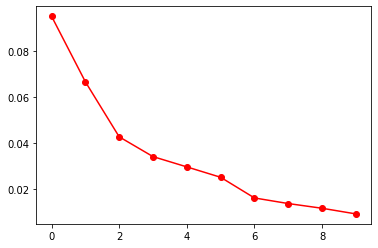

In [85]:
#Apply PCA to the nonanatomical kept terms and print explained variance by component
pca = PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False).fit(concat_maps_anatfilter)
plt.plot(pca.explained_variance_ratio_, 'ro-') 

In [61]:
# save components
components = np.array([dataset.masker.unmask(pca.components_[i],output='array') for i in range(10)])
# np.savez('components',components)

In [52]:
# save the loadings of each term
term_weights = pca.transform(concat_maps_anatfilter)
# np.savez('term_weights',term_weights)

In [53]:
# print ordered list of terms for the first component
kept_terms_anatfilter.iloc[term_weights[:,0].argsort()[::-1]]

1863            motor
1877        movements
1876         movement
1305             hand
1154           finger
            ...      
837          disorder
2531    resting state
2547           reward
1910         negative
957         emotional
Name: term, Length: 950, dtype: object

## Visualize

In [54]:
comps = np.load('components.npz')['arr_0']
comps = comps.transpose(0,3,2,1)

In [55]:
def make_colorvol(proj, meanstds, rgbpcs, mask, flips=tuple(), clip_lim=3):
    rgbdata = proj[rgbpcs,:]
    for f in flips:
        rgbdata[f] *= -1
    zrgb = (rgbdata.T / meanstds).T
    #zrgb = npp.rs(rgbdata.T).T
    crgb = np.clip(zrgb, -clip_lim, clip_lim) ## clip to 3 standard deviations
    srgb = crgb/clip_lim/2.0 + 0.5 ## scale to 0..1
    
    rgbvol = np.zeros([3]+list(mask.shape))
    rgbvol[0] = vox_to_mask(srgb[0], mask)
    rgbvol[1] = vox_to_mask(srgb[1], mask)
    rgbvol[2] = vox_to_mask(srgb[2], mask)

    colorvol = (rgbvol*255).astype(np.uint8)
    return colorvol.transpose(1,2,3,0)

def vox_to_mask(data, mask):
    dvol = mask.copy().astype(np.float)
    dvol[mask>0] = data
    return dvol


In [56]:
flat_comps = comps.reshape(10,-1)
colorvol = make_colorvol(flat_comps, flat_comps.std(1)[:3], [0,1,2], np.ones(comps[0].shape), clip_lim=4)

In [57]:
rgbvol = cortex.dataset.normalize((colorvol, 'fsaverage', 'atlas_2mm'))
rgbvol.alpha.vmin = 0
# cortex.webshow((rgbvol))

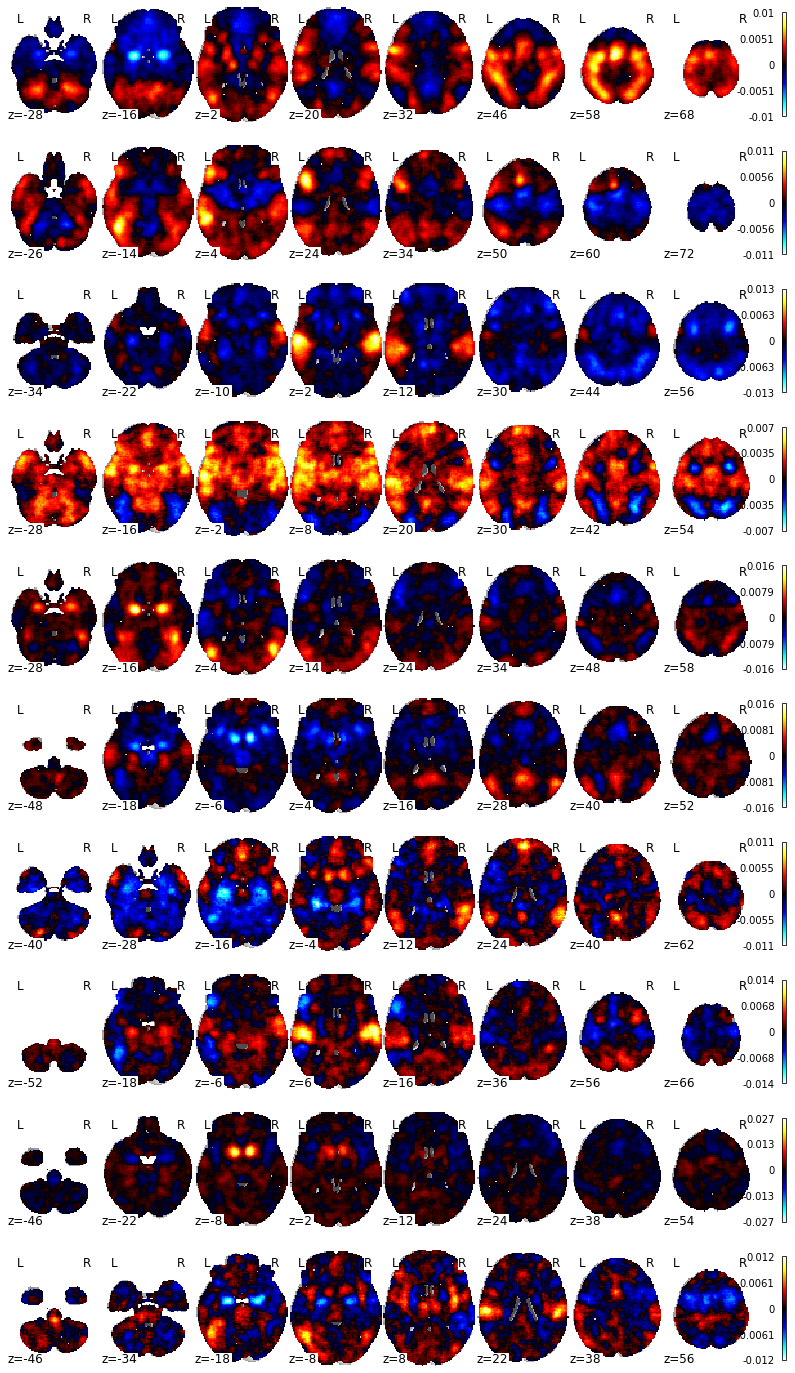

In [58]:
fig, axes = plt.subplots(10, 1, figsize=(14, 25))
for i in range(10):
    img = nilearn.image.new_img_like(dataset.masker.volume, dataset.masker.unmask(pca.components_[i],'array'))
    plotting.plot_stat_map(img, display_mode='z', cut_coords=8, axes=axes[i])
# plt.savefig('10Comps_anatfilter.png', format='png',dpi=300,transparent=True)

## Visualize words

In [71]:
first_three = term_weights[:,0:2]

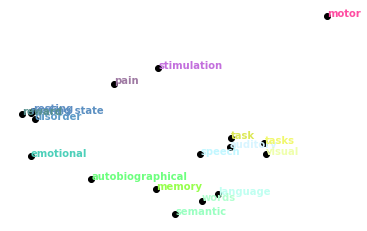

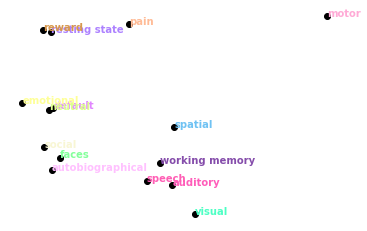

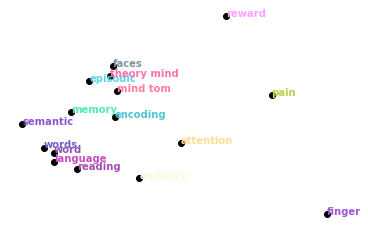

In [101]:
for i in range(3):

    hull = spatial.ConvexHull(term_weights[:, i*3:(i+1)*3])
    vertices = first_three[hull.vertices,:]

    pca = PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
      svd_solver='randomized', tol=0.0, whiten=False).fit(vertices)
    twod_projection = pca.transform(vertices)
    twod_projection

    scaler = MinMaxScaler(feature_range=(0, 0.99))
    scaler = scaler.fit(term_weights[:, i*3:(i+1)*3])
    colors = scaler.transform(term_weights[hull.vertices, i*3:(i+1)*3])
    colors = colors+.3
    colors[colors>1] = 1

    fig, ax = plt.subplots()

    # twod_projection[:,0].shape
    ax.scatter(twod_projection[:,0], twod_projection[:,1], c='black')

    # fig.patch.set_visible(False)
    ax.axis('off')
    for j in range(twod_projection.shape[0]):
        ax.text(twod_projection[j,0],twod_projection[j,1],kept_terms_anatfilter.iloc[hull.vertices[j]], color = colors[j,:], fontweight='bold')

    plt.savefig('wordCloud%d_anatfilter.png'%(i+1), format='png', transparent=True, dpi=300)